In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import imageio
import glob

from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

# Load Data

Data from Kaggle:

In [2]:
df = pd.read_csv('MarathonData.csv', 
                  converters={'id':int, 'Marathon':str, 'Name':str, 'Category':str, 
                              'km4week':float, 'sp4week':float, 'CrossTraining':str,
                              'Wall21':str, 'MarathonTime':float, 'CATEGORY':str})

In [3]:
df = df[df['sp4week'] < 30] #Remove faulty data

In [4]:
df.head()

id  Marathon           Name Category  km4week    sp4week CrossTraining  \
0   1  Prague17   Blair MORGAN      MAM    132.8  14.434783                 
1   2  Prague17  Robert Heczko      MAM     68.6  13.674419                 
2   3  Prague17  Michon Jerome      MAM     82.7  13.520436                 
3   4  Prague17  Daniel Or lek      M45    137.5  12.258544                 
4   5  Prague17   Luk ? Mr zek      MAM     84.6  13.945055                 

  Wall21  MarathonTime CATEGORY  
0   1.16          2.37        A  
1   1.23          2.59        A  
2   1.30          2.66        A  
3   1.32          2.68        A  
4   1.36          2.74        A

In [5]:
train_data, test_data = train_test_split(df, test_size = 0.2, shuffle = True, random_state = 9) 

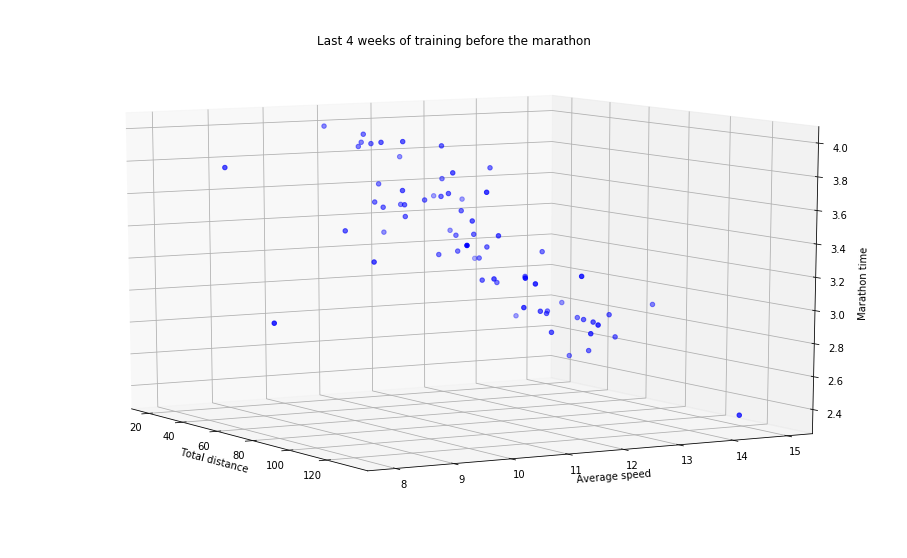

In [6]:
fig = plt.figure(figsize = (16, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(train_data['km4week'], train_data['sp4week'], train_data['MarathonTime'], color = 'b')

ax.set_title('Last 4 weeks of training before the marathon')
ax.set_xlabel('Total distance')
ax.set_ylabel('Average speed')
ax.set_zlabel('Marathon time')

ax.view_init(10, -30)
plt.draw()

# Predictions

Estimate the marathon time using a plane.

In [7]:
def fit_plane(xs, ys, zs):

    tmp_A = []
    tmp_b = []
    for i in range(len(xs)):
        tmp_A.append([xs[i], ys[i], 1])
        tmp_b.append(zs[i])
    b = np.matrix(tmp_b).T
    A = np.matrix(tmp_A)
    fit = (A.T * A).I * A.T * b
    errors = b - A * fit
    residual = np.linalg.norm(errors)
    
    return fit

In [8]:
fit = fit_plane(train_data['km4week'].tolist(), 
                train_data['sp4week'].tolist(), 
                train_data['MarathonTime'].tolist())

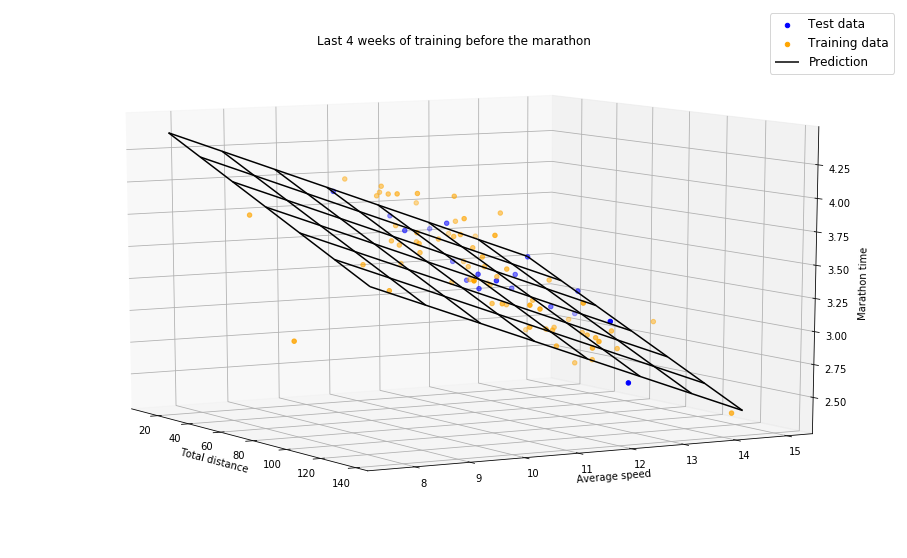

In [9]:
fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111, projection='3d')


#ax.hold(True)
ax.scatter(test_data['km4week'], test_data['sp4week'], test_data['MarathonTime'], color = 'blue', label = 'Test data')
ax.scatter(train_data['km4week'], train_data['sp4week'], train_data['MarathonTime'], color = 'orange', label = 'Training data')

#Plot plane
xlim = ax.get_xlim()
ylim = ax.get_ylim()
X,Y = np.meshgrid(np.arange(xlim[0], xlim[1], 20),
                  np.arange(ylim[0], ylim[1], 1))
Z = np.zeros(X.shape)
for r in range(X.shape[0]):
    for c in range(X.shape[1]):
        Z[r,c] = fit[0] * X[r,c] + fit[1] * Y[r,c] + fit[2]
ax.plot_wireframe(X,Y,Z, color='k', label = 'Prediction')

ax.set_title('Last 4 weeks of training before the marathon')
ax.set_xlabel('Total distance')
ax.set_ylabel('Average speed')
ax.set_zlabel('Marathon time')

ax.legend(loc='upper right', fontsize = 12)

ax.view_init(10, -30)
plt.draw()

saveGIF = False
if saveGIF:
    for angle in range(0, 360):
        ax.view_init(10, angle)
        plt.draw()
        plt.savefig('Plots/Prediction_' + str(angle).zfill(3) + '_angle.png')
        
    filenames = glob.glob('Plots/*.png')
    filenames.sort()
    images = []
    for filename in filenames:
        #print(filename)
        images.append(imageio.imread(filename))
    imageio.mimsave('Prediction.gif', images)

Fit values:

In [10]:
fit

matrix([[-0.00739161],
        [-0.15991104],
        [ 5.7028052 ]])

Calculate predictions:

In [14]:
test_data.loc[:,'Prediction Marathon Time'] = fit[0].item() *  test_data['km4week'] + fit[1].item() * test_data['sp4week'] + fit[2].item()

In [12]:
test_data.loc[:,'Abs Diff Predicion Truth'] = abs(test_data['Prediction Marathon Time'] - test_data['MarathonTime'])

Average absolute error in minutes for the predictions:

In [13]:
print(str(round(test_data['Abs Diff Predicion Truth'].mean() * 60, 2)) + ' min')

6.97 min
